# Sprawozdanie 6
# Jan Izydorczyk

In [1]:
from numpy import float32,float64,log2
import sys
from matplotlib import pyplot as plt
import math
import numpy as np
import random
import scipy
%matplotlib notebook

print("Wersja Pythona:")
print (sys.version)
print(f"Wersja numpy: {np.__version__}")
print("Konfiguracja liczb zmiennoprzecinkowych")
print(sys.float_info)

f64 = np.float64
f32 = np.float32

Wersja Pythona:
3.9.4 (tags/v3.9.4:1f2e308, Apr  6 2021, 13:40:21) [MSC v.1928 64 bit (AMD64)]
Wersja numpy: 1.20.2
Konfiguracja liczb zmiennoprzecinkowych
sys.float_info(max=1.7976931348623157e+308, max_exp=1024, max_10_exp=308, min=2.2250738585072014e-308, min_exp=-1021, min_10_exp=-307, dig=15, mant_dig=53, epsilon=2.220446049250313e-16, radix=2, rounds=1)


# Zadanie 1

In [2]:
def solve_gauss_jordan(M, Y):
    n = M.shape[0]
    M = np.copy(M).astype('float64')
    X = np.copy(Y).astype('float64')
    for i in range(n):
#         print(X)
        for j in range(i, n):
            if M[j, i] != 0:
                M[[j,i]] = M[[i, j]]
                X[[j, i]] = X[[i, j]]
                break
        X[i, :] = X[i, :] / M[i,i]
        M[i, :] = M[i, :] / M[i,i]  
        for j in range(0, n):
            if j == i:
                continue
            X[j, :] = X[j, :] - (X[i, :] / M[i,i] * M[j, i])
            M[j, :] = M[j, :] - (M[i, :] / M[i,i] * M[j, i])
    return X

In [3]:
M = np.array([
    [3, 2, 3],
    [3, 2, 1],
    [5, 6, 1]
])

Y = np.array([1, 2, 3])
Y.shape = (-1, 1)

print(np.allclose(np.linalg.solve(M, Y) - solve_gauss_jordan(M, Y), 0))

True


In [4]:
def make_bar_data(data, labels, title, plot=None):
    if not plot:
        fig, ax = plt.subplots()
    else:
        fig, ax = plot
#     ax.set_yscale('log')
    x = np.arange(len(labels))  # the label locations
    width = 0.8  # the width of the bars
    rects = ax.bar(x, data, width)
    ax.bar_label(rects, padding=2)

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel('czas [ms]')
    
    fig.suptitle(title)
    fig.tight_layout()

    return fig, ax

In [5]:
from timeit import timeit

def compare_jordan_bars(n):
    M = np.random.rand(n, n)
    Y = np.random.rand(n, 1)

    times = [
        timeit(lambda: np.linalg.solve(M, Y), number=10) * 1000,
        timeit(lambda: solve_gauss_jordan(M, Y), number=10) * 1000
    ]

    labels = [
        'np_solve',
        'own_gauss_jordan_solve'
    ]

    title = f'Porównanie czasów dla funkcji rozwiązujących układ {n} równań'
    make_bar_data(times, labels, title)

In [20]:
from itertools import chain, product
from timeit import timeit
import pandas as pd
from mpmath import nstr, mpf
data = []

names = ['Equation', 'A1', 'A2', 'A3']

funs = [np.linalg.solve, solve_gauss_jordan]

ns = np.arange(3, 8)

for n in ns:
    n_2 = 2**n
    d = [f'2e{n}']
    M = np.random.rand(n_2, n_2)
    Y = np.random.rand(n_2, 1)
    for f in funs:
        t = timeit(lambda: f(M, Y), number=10)* 1000
        d += [f.__name__, nstr(mpf(t), 3)]
    data.append(d)

pd.DataFrame(data, columns=['n', 'Function', 'Time[ms]', 'Function', 'Time[ms]'])

n Function Time[ms]            Function Time[ms]
0  2e3    solve    0.137  solve_gauss_jordan     12.4
1  2e4    solve    0.167  solve_gauss_jordan     25.6
2  2e5    solve     3.26  solve_gauss_jordan     83.7
3  2e6    solve      6.4  solve_gauss_jordan    303.0
4  2e7    solve     11.0  solve_gauss_jordan  1.41e+3

Własna funkcja działa o ponad cały rząd wielkości wolniej, niż funkcja biblioteczna (co nie dziwi, numpy'owe fukcje są w pełni zoptymalizowane w C). 

Metoda Guassa-Jordana od razu daje nam bezpośrednio wynik, w eliminacji Gaussa trzeba dokonać redukcji. Jednak zwykła eliminacja szybciej pozwala nam ustalić rząd macierzy oraz proces redukcji może być lepiej zoptymalizowany, co może zmniejszyć stałą.  

# Zadanie 2

In [51]:
#wzór z wykładu, nie wiem w którym miejscu mam zastosować skalowanie znajdowanie elementu wiodącego ;<

def LU_Doolittle(A):
    LU = np.zeros(shape=A.shape, dtype=f64)
    A = np.copy(A)
    n = A.shape[0]
    # skalowanie 
    for row in A:
        row = row / np.max(row)        
    for i in range(n):
        for j in range(n):
            if i <= j:
                LU[i, j] = A[i, j] - np.dot(LU[i, :i], LU[:i, j])
            else:
                LU[i, j] = (A[i, j] - np.dot(LU[i, :j], LU[:j, j])) / LU[j,j]
    L = np.tril(LU, -1)
    np.fill_diagonal(L, 1)
    U = np.triu(LU)
    return LU, L, U
            

In [52]:
n = 10
A = np.random.rand(n, n)

LU, L, U = LU_Doolittle(A)
B = np.copy(A)
for row in B:
    row = row / np.max(row) 
print(np.allclose(B-L@U, 0))

True


In [53]:
def solve_UL(A, Y, L=None, U = None):
    n = A.shape[0]
    if U is None:
        _, L, U = LU_Doolittle(A)
    X = np.zeros(shape = Y.shape)
    Z = np.copy(X)
    
    Z[0, 0] = Y[0, 0] / L[0, 0]
    for i in range(1, n):
        Z[i, 0] = (Y[i, 0] - np.dot(L[i, :i], Z[:i, 0])) / L[i, i]
    
    X[-1, 0] = Z[-1, 0] / U[-1, -1]
    for i in range(n-2, -1, -1):
        X[i, 0] = (Z[i, 0] - np.dot(U[i, i+1:], X[i+1:, 0])) / U[i, i]
    return X

In [54]:
n = 10
A = np.random.rand(n, n)
Y = np.random.rand(n, 1)

X_UL = solve_UL(A, Y)
X_NP = np.linalg.solve(A, Y)

print(np.allclose(X_UL-X_NP, 0))

True


Mając rozkład *LU* można na potraktować równanie
$$ A \cdot X = Y $$
jako
$$(LU) \cdot X = Y$$
podstawiając 
$$ U \cdot X = Z $$
$$ L \cdot Z = Y $$
Mamy dwa równanania, gdzie macierze *L* i *U* są oczywiście trójkątne, przez co każde da się rozwiązać w czasie $O(n^2)$ (poprzez podstawianie wsteczne). Daje to możliwość rozwiązywania równania dla danej macierzy *A* w czasie kwadratowym dla dowolnych wektorów *Y* (po uwczesnym preprocesingu w czasie sześciennym).

### Porównanie przy memoizacji LU

In [27]:
def compare_LU_bars(n, k):
    M = np.random.rand(n, n)
    Ys = np.random.rand(k, n, 1)
    
    def linalg_test():
        nonlocal Ys, M;
        for Y in Ys:
            np.linalg.solve(M, Y)
            
    def LU_test():
        nonlocal Ys, M
        _, L, U = LU_Doolittle(M)
        for Y in Ys:
            solve_UL(M, Y, L, U)
    
    times = [
        timeit(linalg_test, number=10) * 1000,
        timeit(LU_test, number=10) * 1000
    ]

    labels = [
        'np_solve',
        'own_UL_jordan_solve'
    ]

    title = f'Porównanie czasów dla funkcji rozwiązujących układ {n} równań\ndla {k} wektorów'
    make_bar_data(times, labels, title)

In [29]:
from itertools import chain, product
from timeit import timeit
import pandas as pd
from mpmath import nstr, mpf
data = []



ns = np.arange(3, 8)
ks = np.arange(1, 9)

def linalg_test(M, Ys):
        for Y in Ys:
            np.linalg.solve(M, Y)
            
def LU_test(M, Ys):
    _, L, U = LU_Doolittle(M)
    for Y in Ys:
        solve_UL(M, Y, L, U)
        
funs = [linalg_test, LU_test]

for n, k in product(ns, ks):
    n_2 = 2**n
    k_2 = 2**k
    d = [f'2e{n}', f'2e{k}']
    M = np.random.rand(n_2, n_2)
    Ys = np.random.rand(k_2, n_2, 1)
    
    for f in funs:
        t = timeit(lambda: f(M, Ys), number=10)* 1000
        d += [f.__name__, nstr(mpf(t), 3)]
    data.append(d)

pd.DataFrame(data, columns=['n', 'k', 'Function', 'Time[ms]', 'Function', 'Time[ms]'])

n    k     Function Time[ms] Function Time[ms]
0   2e3  2e1  linalg_test    0.234  LU_test     7.07
1   2e3  2e2  linalg_test    0.458  LU_test      3.5
2   2e3  2e3  linalg_test    0.726  LU_test     4.46
3   2e3  2e4  linalg_test     1.94  LU_test     8.28
4   2e3  2e5  linalg_test     2.77  LU_test     14.5
5   2e3  2e6  linalg_test     8.06  LU_test     26.4
6   2e3  2e7  linalg_test     11.9  LU_test     43.6
7   2e3  2e8  linalg_test     20.4  LU_test     84.3
8   2e4  2e1  linalg_test    0.267  LU_test     6.55
9   2e4  2e2  linalg_test    0.443  LU_test     8.09
10  2e4  2e3  linalg_test    0.851  LU_test     10.4
11  2e4  2e4  linalg_test     1.61  LU_test     15.6
12  2e4  2e5  linalg_test     3.31  LU_test     26.1
13  2e4  2e6  linalg_test     6.38  LU_test     47.2
14  2e4  2e7  linalg_test     15.5  LU_test     91.5
15  2e4  2e8  linalg_test     24.7  LU_test    197.0
16  2e5  2e1  linalg_test     8.93  LU_test     29.3
17  2e5  2e2  linalg_test     13.3  LU_test     29.8
18  2e5  2e3  linalg_test     35.6  LU_test     42.6
19  2e5  2e4  linalg_test    106.0  LU_test     55.9
20  2e5  2e5  linalg_test    103.0  LU_test     79.2
21  2e5  2e6  linalg_test    178.0  LU_test    116.0
22  2e5  2e7  linalg_test    434.0  LU_test    241.0
23  2e5  2e8  linalg_test    705.0  LU_test    398.0
24  2e6  2e1  linalg_test     12.4  LU_test     89.6
25  2e6  2e2  linalg_test     52.4  LU_test    113.0
26  2e6  2e3  linalg_test     63.4  LU_test    106.0
27  2e6  2e4  linalg_test     90.4  LU_test    156.0
28  2e6  2e5  linalg_test    253.0  LU_test    213.0
29  2e6  2e6  linalg_test    418.0  LU_test    327.0
30  2e6  2e7  linalg_test    914.0  LU_test    505.0
31  2e6  2e8  linalg_test  2.48e+3  LU_test  1.17e+3
32  2e7  2e1  linalg_test     59.0  LU_test    536.0
33  2e7  2e2  linalg_test     90.9  LU_test    650.0
34  2e7  2e3  linalg_test    181.0  LU_test    460.0
35  2e7  2e4  linalg_test    499.0  LU_test    448.0
36  2e7  2e5  linalg_test    366.0  LU_test    496.0
37  2e7  2e6  linalg_test    702.0  LU_test    688.0
38  2e7  2e7  linalg_test  1.32e+3  LU_test    998.0
39  2e7  2e8  linalg_test  3.82e+3  LU_test  1.79e+3

Faktoryzacja LU przy spamiętywaniu wartości *L* i *U*, dla wielu niezależnych wektorów *Y* pozwala na o wiele efektywniejsze rozwiązywanie równań. Już dla wielkości macierzy $2^5\times 2^5$ i dla $2^4$ Y'ków własna funkcja, napisana po części w Pythonie, wyprzedza *np.linalg.solve* napisanego w czystym C, co pokazuję przewagę tej metody. Należy zauważyć, że metoda ta staje się bardziej efektywna, kiedy rząd wartości *k* zaczyna się zbliżać do rzędu wielkości *n*. Mimo wszystko różnica stałych jest znacząca.

# Zadanie 3

In [30]:
import colorsys
def scale_saturation(c, scale):
    r,g,b = c
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    return colorsys.hls_to_rgb(h, l, min(1, s * scale))

In [36]:
def plot_points(points, arrow_points, title='', figsize=10, maxlim=1, fig=None, ax=None):
    plot = True
    if fig is None:
        fig = plt.figure(figsize=(figsize, figsize))
        ax = fig.add_subplot(111, projection='3d')
        plot = False
    
    x, y, z = map(list, zip(*points))
    t = np.arange(len(points))
    ax.scatter(x, y, z, c = t, marker='.', cmap='jet')
    for ap in arrow_points:
        ax.quiver(0,0,0,*ap)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    ax.axes.set_xlim3d(left=min(x + [-maxlim]), right=max(x + [maxlim]))
    ax.axes.set_ylim3d(bottom=min(y + [-maxlim]), top=max(y + [maxlim]))    
    ax.axes.set_zlim3d(bottom=min(z + [-maxlim]), top=max(z + [maxlim]))
    fig.suptitle(title)
    if plot:
        plt.show()
    return fig, ax

<IPython.core.display.Javascript object>


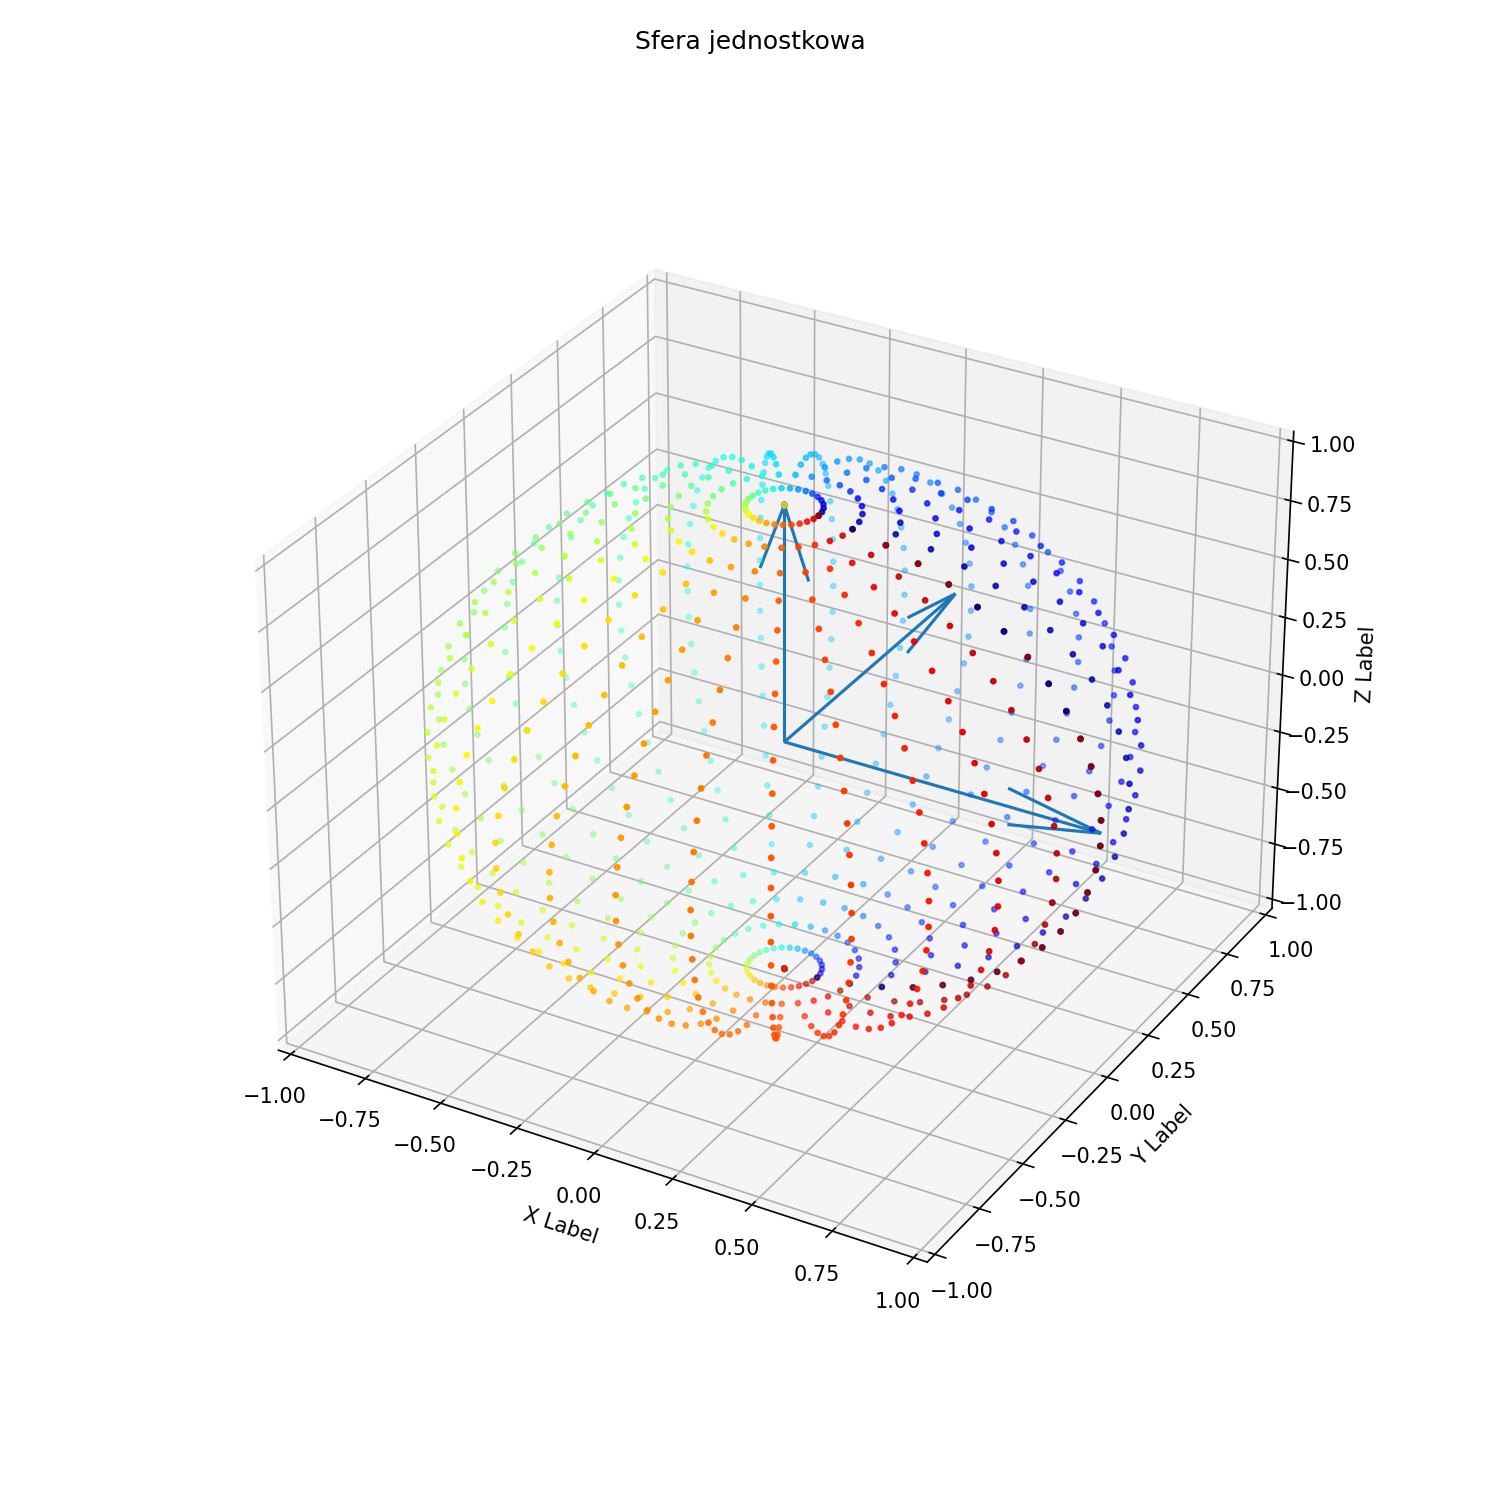

(<Figure size 1000x1000 with 1 Axes>,
 <Axes3DSubplot:xlabel='X Label', ylabel='Y Label'>)

In [37]:
from itertools import product


def get_sphere_points(dim_density= 100):
    ss = np.linspace(0, 2*np.pi, dim_density)
    ts = np.linspace(0, np.pi, dim_density)
    x_f = lambda s, t: np.cos(s)*np.sin(t)
    y_f = lambda s, t: np.sin(s)*np.sin(t)    
    z_f = lambda s, t: np.cos(t)
    return [np.array([x_f(s, t), y_f(s, t), z_f(s, t)]) for s, t in product(ss, ts)]
base = [[0, 0, 1], [0, 1, 0], [1, 0, 0]]
sphere_points = get_sphere_points(30)
plot_points(sphere_points, base, title='Sfera jednostkowa')

In [40]:
A1, A2, A3 = np.random.rand(3, 3, 3)

<IPython.core.display.Javascript object>


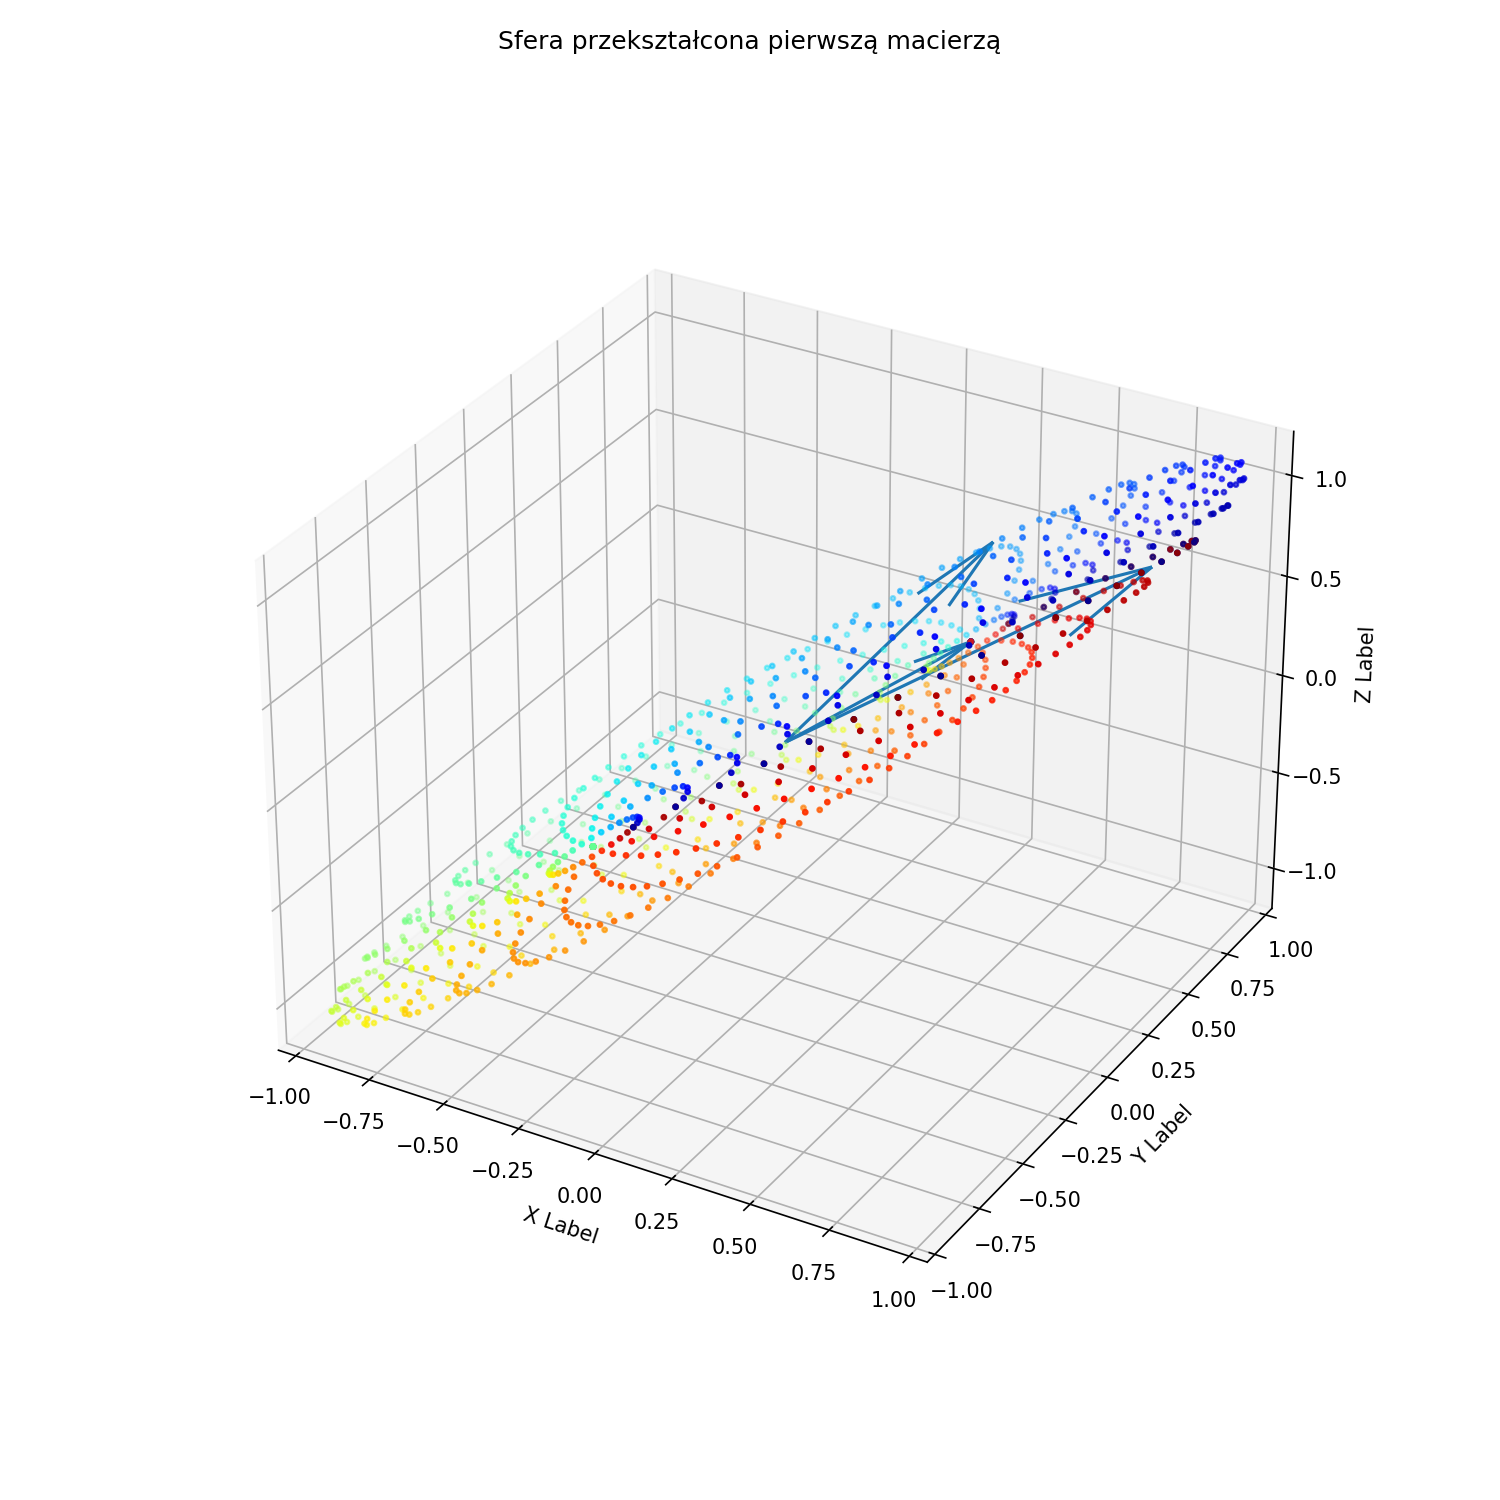

(<Figure size 1000x1000 with 1 Axes>,
 <Axes3DSubplot:xlabel='X Label', ylabel='Y Label'>)

In [41]:
S1 = sphere_points@A1
B1 = base @ A1
plot_points(S1, B1, title='Sfera przekształcona pierwszą macierzą')

<IPython.core.display.Javascript object>


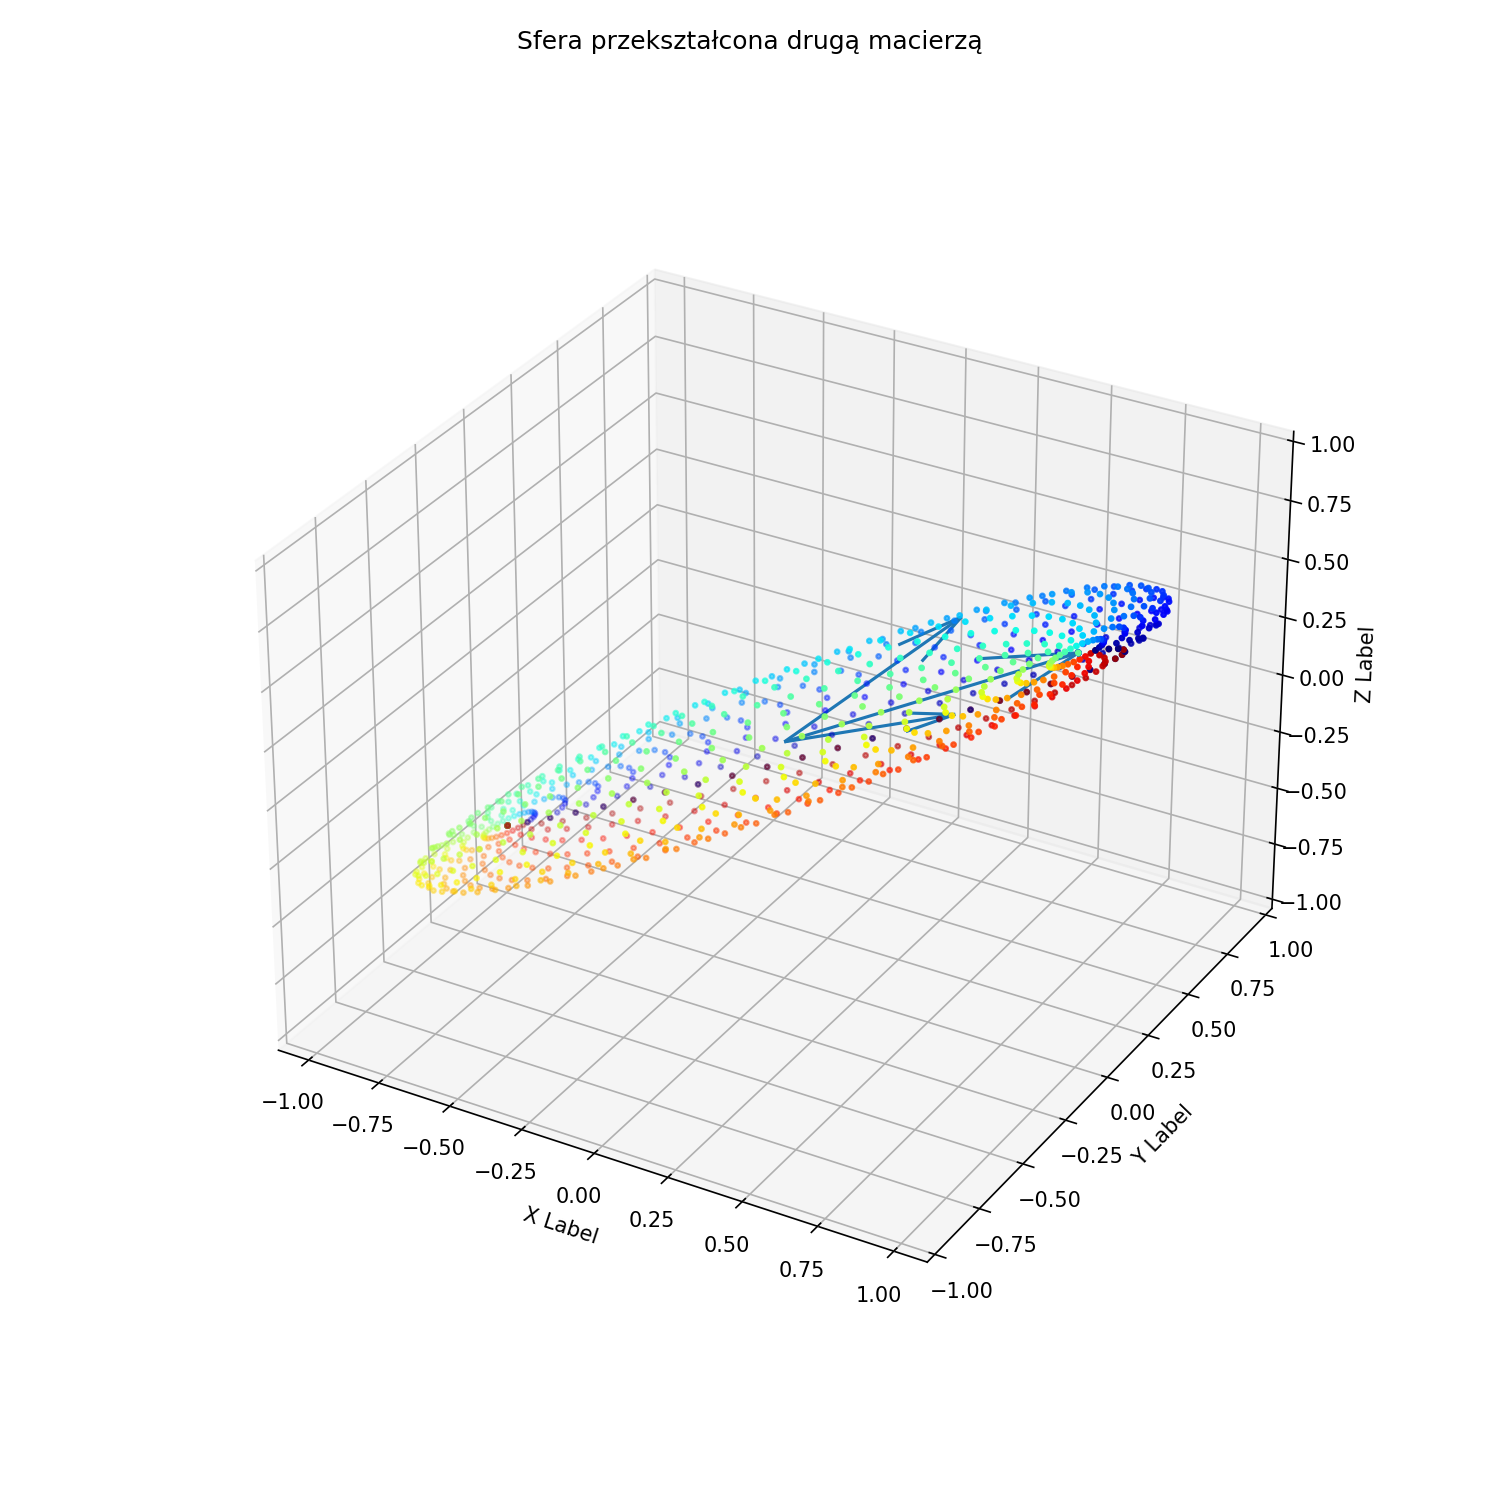

(<Figure size 1000x1000 with 1 Axes>,
 <Axes3DSubplot:xlabel='X Label', ylabel='Y Label'>)

In [42]:
S2 = sphere_points@A2
B2 = base @ A2
plot_points(S2, B2, title='Sfera przekształcona drugą macierzą')

<IPython.core.display.Javascript object>


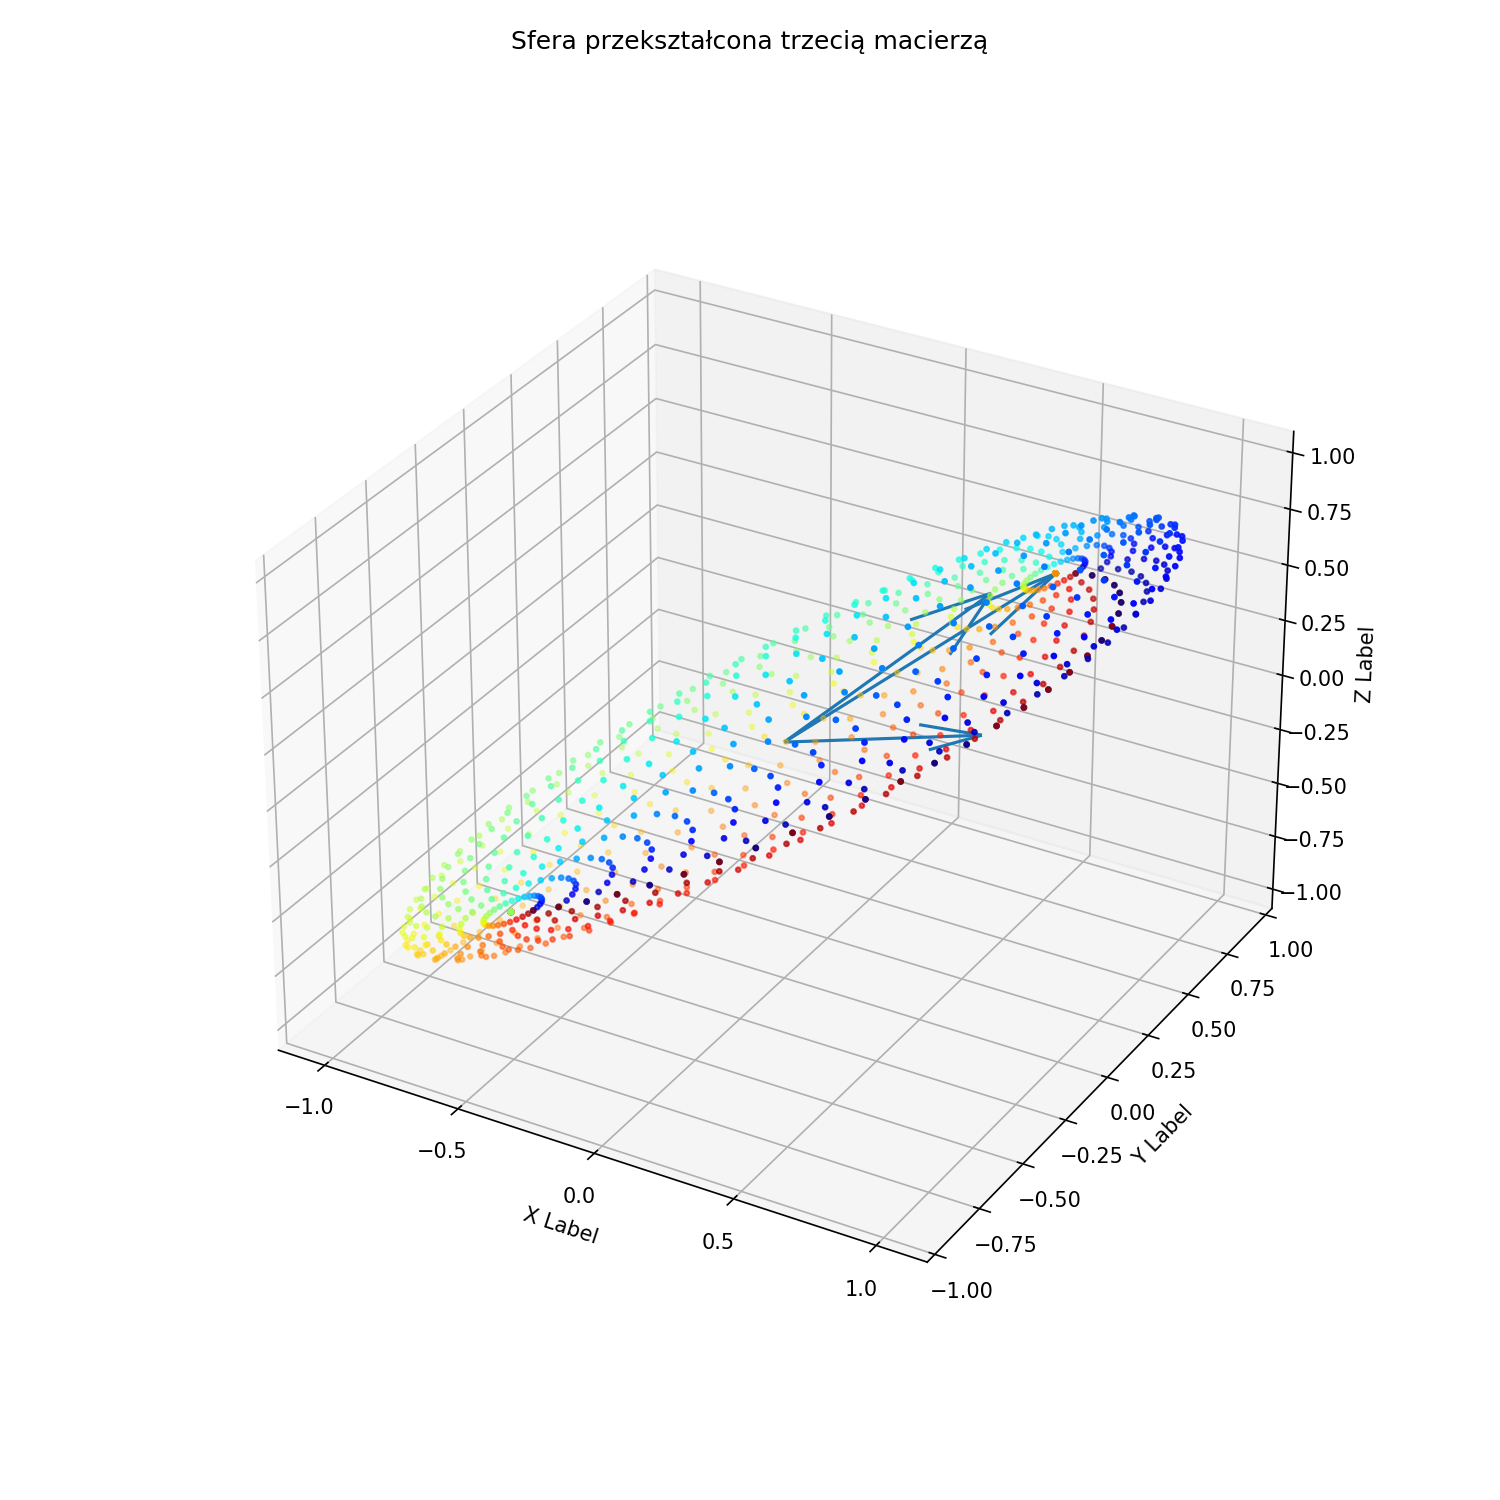

(<Figure size 1000x1000 with 1 Axes>,
 <Axes3DSubplot:xlabel='X Label', ylabel='Y Label'>)

In [43]:
S3 = sphere_points @ A3
B3 = base @ A3
plot_points(S3, B3, title='Sfera przekształcona trzecią macierzą')

In [44]:
U1, S1, VH1 = np.linalg.svd(A1, full_matrices=True)
S1 = np.diag(S1)

<IPython.core.display.Javascript object>


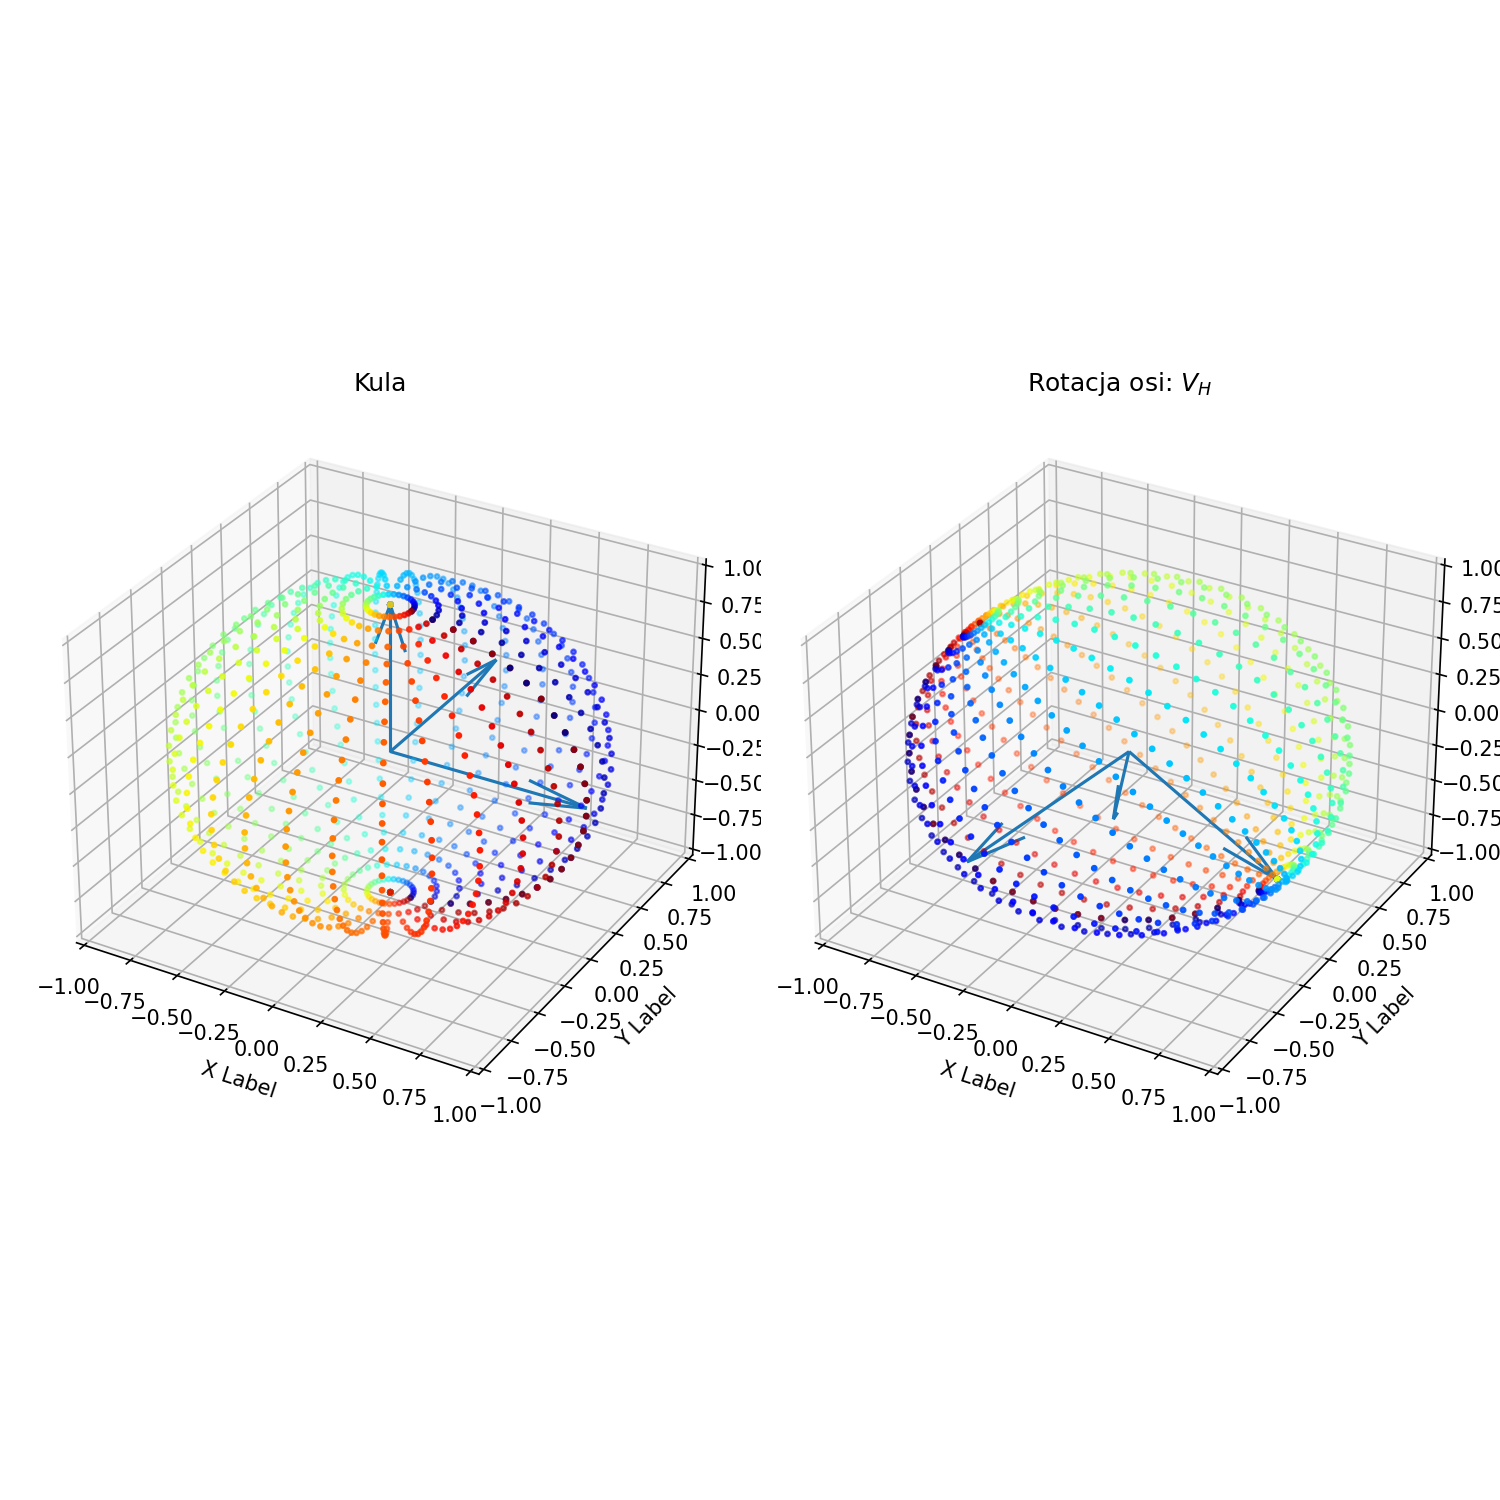

In [45]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Pierwsza macierz')
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title('Kula')
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title('Rotacja osi: $V_H$')

S = np.copy(sphere_points)
B = np.copy(base)

plot_points(S, B, fig=fig, ax=ax1)
plot_points(S @ VH1, B @ VH1, fig=fig, ax=ax2)
fig.tight_layout()

<IPython.core.display.Javascript object>


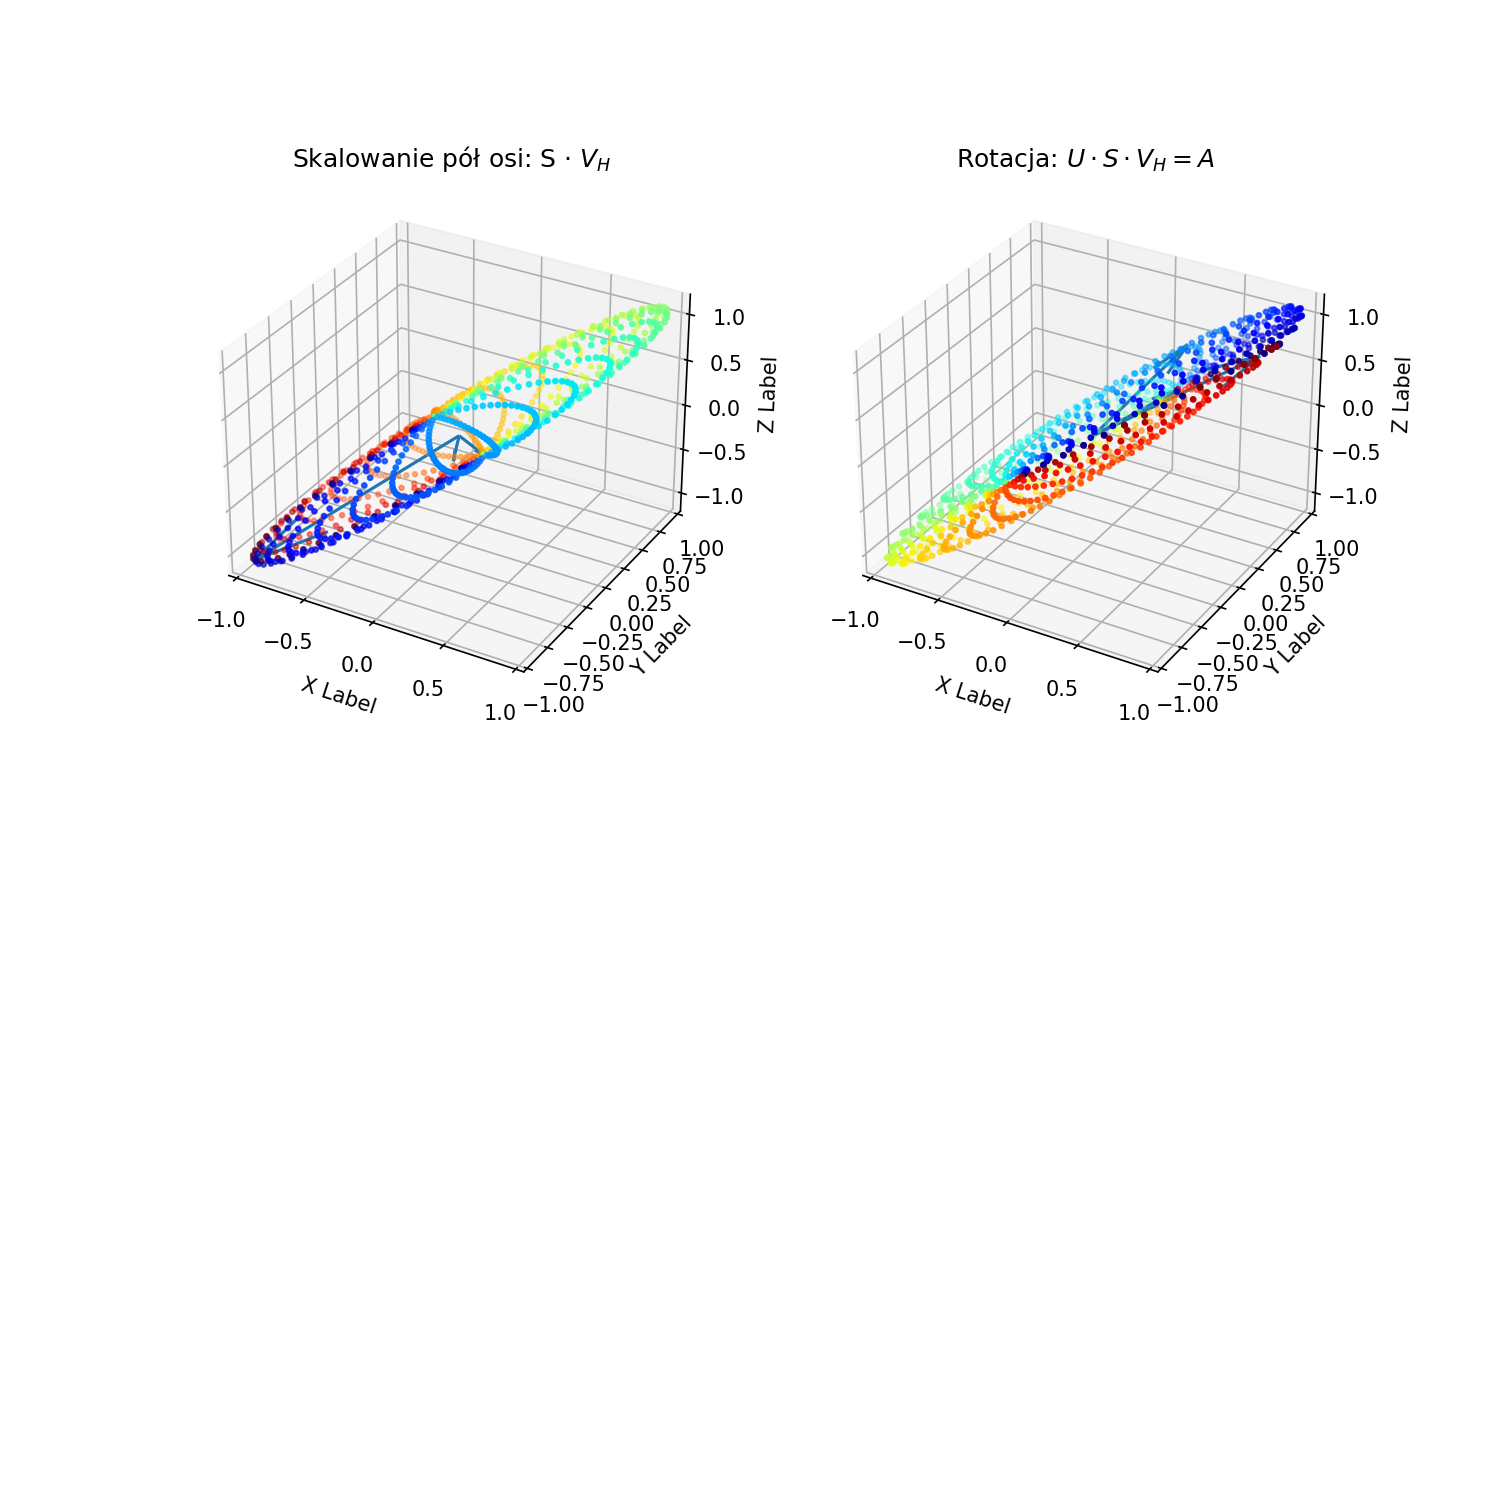

(<Figure size 1000x1000 with 2 Axes>,
 <Axes3DSubplot:title={'center':'Rotacja: $U \\cdot S \\cdot V_H = A$'}, xlabel='X Label', ylabel='Y Label'>)

In [46]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Pierwsza macierz')
ax3 = fig.add_subplot(221, projection='3d')
ax3.set_title('Skalowanie pół osi: S $\cdot$ $V_H$')
ax4 = fig.add_subplot(222, projection='3d')
ax4.set_title('Rotacja: $U \cdot S \cdot V_H = A$')

plot_points(sphere_points @ S1 @ VH1, base @ S1  @ VH1, fig=fig, ax=ax3)
plot_points(sphere_points @ U1 @ S1 @ VH1, base @ U1 @ S1 @ VH1, fig=fig, ax=ax4)

1. Sfera jednostkowa, brak przekształcen
2. Rotacja, cały układ jest rotowany w 3D
3. Skalowanie pół osi elipsy, pół osie są skalowane przez kolejne osobliwe (własne macierzy $A^T \cdot A$)
4. Ponowna rotacja układu

In [147]:
A = np.random.rand(3, 3)
U, S, VH = np.linalg.svd(A)
S[0] = S[2] + 100
A = (U * S) @ VH

print(A)

[[47.15527294 27.96152631 26.13786185]
 [47.12210398 28.01448075 26.72936593]
 [39.78367623 23.4345942  21.70844671]]


<IPython.core.display.Javascript object>


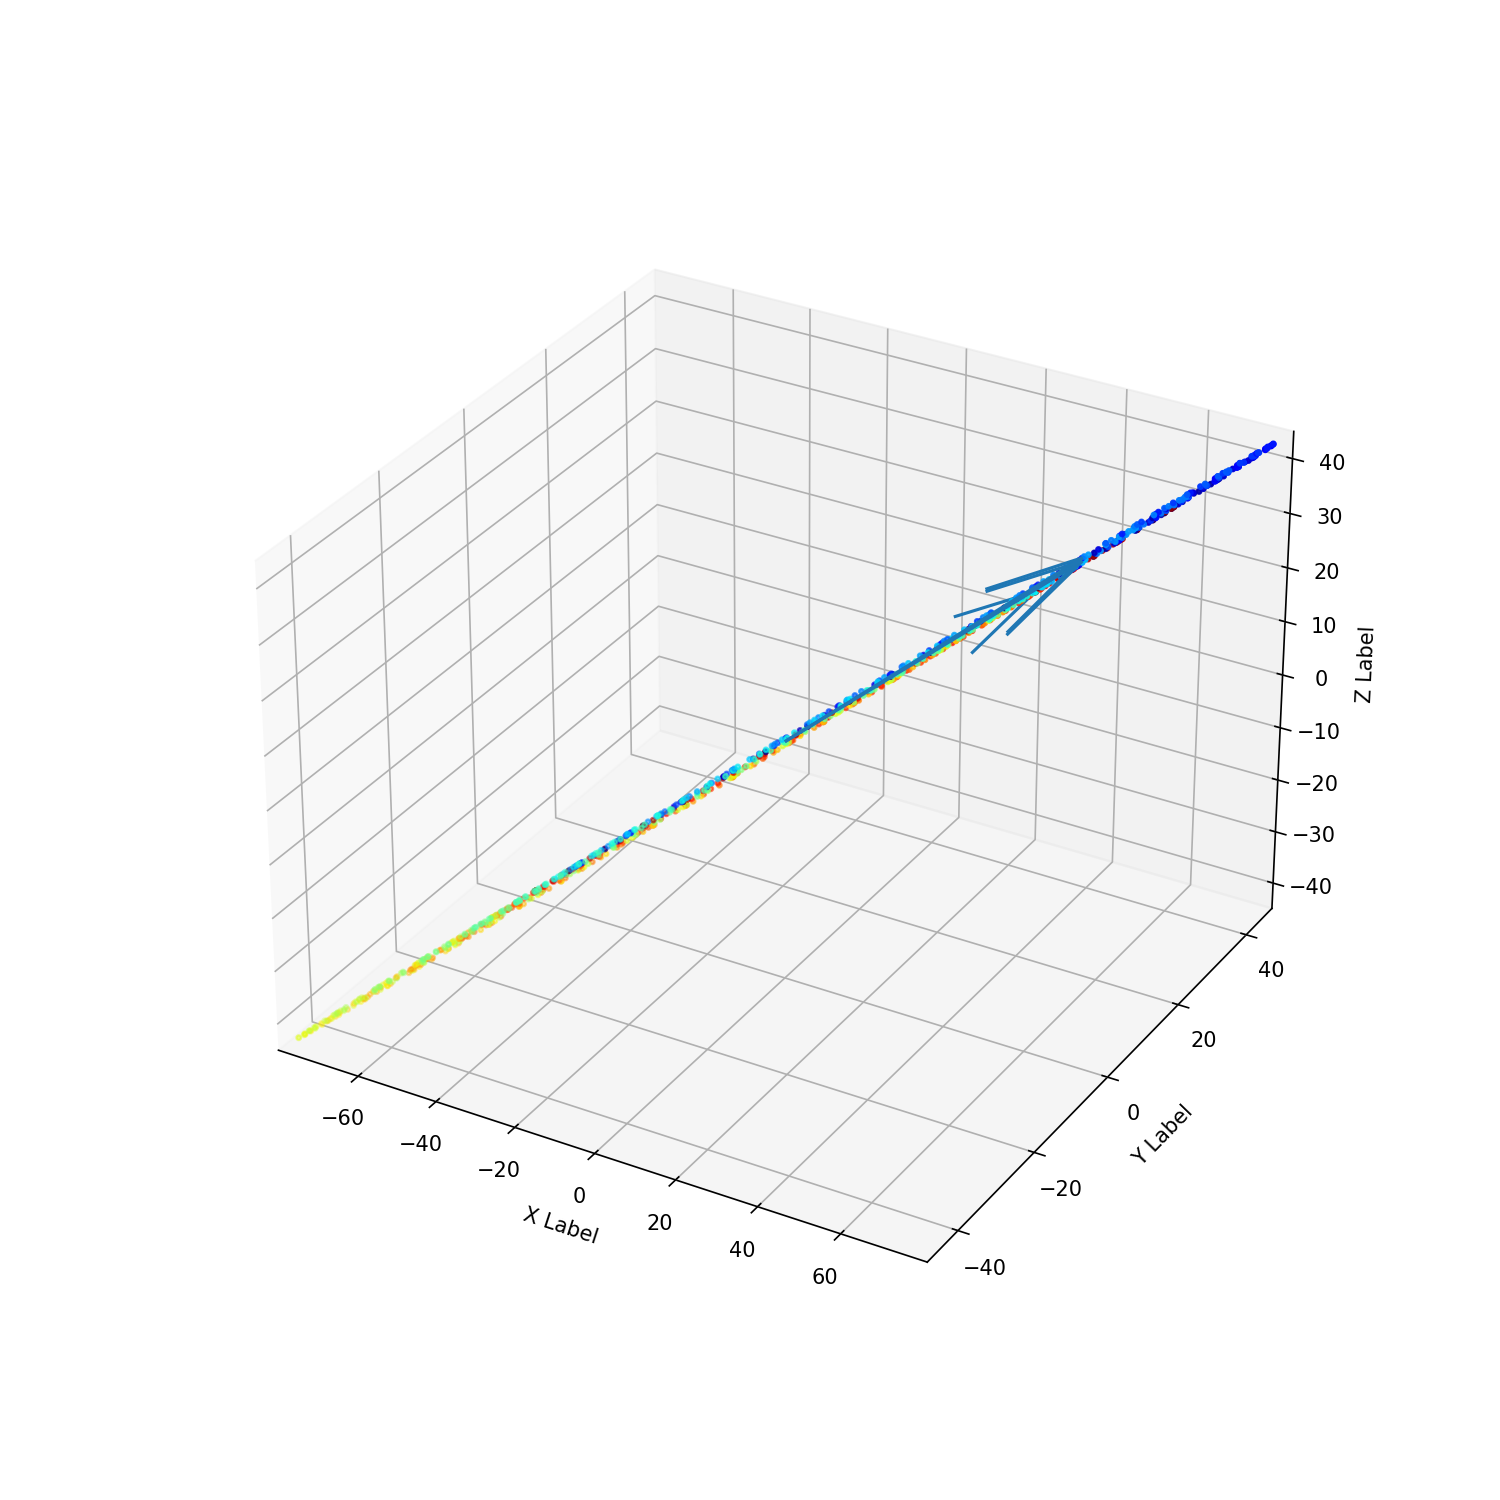

(<Figure size 1000x1000 with 1 Axes>,
 <Axes3DSubplot:xlabel='X Label', ylabel='Y Label'>)

In [148]:
plot_points(sphere_points @ A, base @ A)

Wygenerowana elipsoida została wizualnie zredukowana do jednego wymiaru. Wynika to z tego, że pół osie elipsy (jako, że wygenerowaliśmy kule jednostkową) mają długośc odpowiadające wartościomk osobliwym macierzy. Przez znaczną różnicę kilku rzędów miedzy wartościami, najdłuższa oś jest znacznie dłuższa, niż pozostałe. 

# Zadanie 4

In [56]:
M1 = np.array([
    [0.835, 0.667],
    [0.333, 0.267]
])

Y = np.array([
    [0.168],
    [0.067],
])

In [57]:
X1 = np.linalg.solve(M1, Y)

print(f'x = {X1[0]} y = {X1[1]}')

x = [0.20023981] y = [0.00119904]


In [58]:
M2 = np.array([
    [0.835, 0.666],
    [0.333, 0.267]
])

In [59]:
X2 = np.linalg.solve(M2, Y)

print(f'x = {X2[0]} y = {X2[1]}')

x = [0.20051414] y = [0.0008569]


In [60]:
abs(X1 - X2)

array([[0.00027433],
       [0.00034214]])

Różnica jest rzędu całkiem znacząca.

In [ ]:
plot_points(sphere_points @ A, base @ A)

In [62]:
_, S, _ = np.linalg.svd(M1)
our_diff = abs(S[0] - S[-1])

_, S, _ = np.linalg.svd(M1)
our_diff = abs(S[0] - S[-1])
print(f'Różnica między największą i najmniejsza wartością osobliwą: {nstr(mpf(our_diff), 3)}')

Różnica między największą i najmniejsza wartością osobliwą: 1.15


Układ jest źle uwarunkowany, znaczmna róznica miedzy wartościami osobliwymi wskazuje, że przekształcenie zaczyna przypominać zredukowaną do jednwgo wymiaru prostą. Ogólnie układ reprezentuje dwie proste o podobnym nachyleniu, co ponownie źle uwarunkowuje rozwiązanie.

In [68]:
from itertools import chain
import pandas as pd
data = []
precision = 50

names = ['Equation', 'A1', 'A2', 'A3']
    
for mat, name in zip(chain([M1], np.random.rand(3, 2, 2)), names):
    _, S, _ = np.linalg.svd(mat)
    diff = abs(S[0] - S[-1])
    data.append([name, nstr(mpf(diff), 3)])

pd.DataFrame(data, columns=['Name', 'Difference'])

Name Difference
0  Equation       1.15
1        A1      0.806
2        A2       0.75
3        A3      0.645

Różnice dla losowych macierzy są mniejsze, chociaż posiadają podobne rzędy wielkości. Wizualizajca kul pokazywała, że losowe macierze dosyć często redukują przekształcenie do niższych wymiarów, tutaj dla równania te różnice sa jeszcze większe.